In [1]:
import os
import numpy as np
import pylab as plt
import scipy.signal as sg
import sounddevice as sd
import pandas as pd
from time import sleep
from sklearn.model_selection import train_test_split
plt.rcParams['axes.grid'] = True

In [122]:
data_dir = '.'
x_global_train = np.load(os.path.join(data_dir, 'train.npz'))['x']
y_global_train = np.load(os.path.join(data_dir, 'train.npz'))['y']
x_global_test  = np.load(os.path.join(data_dir, 'test.npz'))['x']
x_train, x_test, y_train, y_test = train_test_split(x_global_train, y_global_train, stratify=y_global_train, shuffle=True, train_size=0.9)
fs = 16000
print(x_test.shape, y_test.shape, x_global_test.shape)

(225, 16000) (225,) (750, 16000)


In [3]:
from sklearn.metrics import accuracy_score

(501,) (2025, 501)


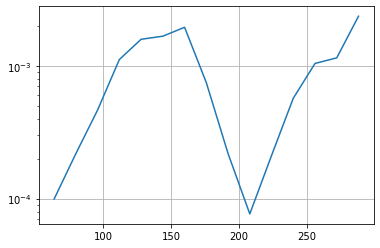

In [143]:
# plot a spectrum of some sample
freq, x_spec_train = sg.welch(x_train, 16000, axis=1, nperseg=1000)
print(freq.shape, x_spec_train.shape)
freq_filtered = (freq > 50) & (freq < 300)
plt.semilogy(freq[freq_filtered], x_spec_train[1][freq_filtered])

In [154]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.ensemble import GradientBoostingClassifier

clf1 = GradientBoostingClassifier(max_depth=3, min_samples_leaf=0.1)
clf2 = GradientBoostingClassifier(max_depth=4, min_samples_leaf=0.08)
clf3 = GradientBoostingClassifier(max_depth=5, min_samples_leaf=0.08)

from sklearn.base import BaseEstimator, TransformerMixin

def moving_average(a, n=3) :
    ret = np.cumsum(a, dtype=float, axis=1)
    ret[:, n:] = ret[:, n:] - ret[:, :-n]
    return ret[:, n - 1:] / n

class MyTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X):
        freq, x_spec = sg.welch(X, 16000, axis=1, nperseg=1000)
        
        return x_spec
        return np.concatenate((x_spec[:, freq_filtered],x_spec1[:, freq_filtered1]),axis=1)

    
class MovingAverageTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y = None):
        return self
    
    def transform(self, X):
        X = X.copy()
        X = moving_average(X, 40)
        return X
    
    
column_transformer = ColumnTransformer([
    ('my_transform', MyTransformer(), slice(0, fs)),
    ('moving_average_transform', MovingAverageTransformer(), slice(0, 100)),
], sparse_threshold=0)

pipeline = Pipeline(steps=[
    ('colum_transform', column_transformer),
    ('scale', StandardScaler()),
    ('regression', VotingClassifier(estimators=[
        ('lr', clf1),
        ('lr2', clf2),
        ('lr3', clf3),
    ], voting='hard'))
])

model = pipeline.fit(x_train, y_train - 2)

y_train_pred = model.predict(x_train) + 2
y_test_pred = model.predict(x_test) + 2

print("train accuracy", accuracy_score(y_train_pred, y_train))
print("test accuracy", accuracy_score(y_test_pred, y_test))

train accuracy 0.9846913580246913
test accuracy 0.8222222222222222


In [155]:
y_global_test_pred = model.predict(x_global_test) + 2
np.savetxt('y_test.txt', y_global_test_pred.astype(int), encoding='utf-8', fmt='%i')